### Intro

Our model of choice for blood disorders classification with group detalization is CatBoostClassifier. Here we present the training, tuning, and result intepretation.

In [8]:
import numpy as np
import pandas as pd

In [9]:
data = pd.read_excel("./small_with_healthy.xlsx")

In [10]:
data.drop(columns="Unnamed: 0", inplace=True)
data

,client_id,age,диагноз клинический,grouped_diagnosis,Базофилы[00029],Базофилы[00030],Гематокрит[00003],Гемоглобин[00001],Лейкоциты[00010],Лимфобласты[ЛФ_Лимфобласты],...,Общий белок[1.11.1.1],Холестерин[1.11.1.7],gender,Анизоцитоз[ЛФ_Анизоцитоз]_+,Анизоцитоз[ЛФ_Анизоцитоз]_++,Анизоцитоз[ЛФ_Анизоцитоз]_+++,Анизоцитоз[ЛФ_Анизоцитоз]_-,Пойкилоцитоз[ЛФ_Пойкилоцитоз]_+,Пойкилоцитоз[ЛФ_Пойкилоцитоз]_++,Пойкилоцитоз[ЛФ_Пойкилоцитоз]_+++
0,166697,51.0,C90.0,C90,NaN,NaN,0.28,92.0,7.00,NaN,...,66.6,6.89,0,0,0,0,0,0,0,0
1,164649,70.0,C90.0,C90,NaN,NaN,0.40,NaN,3.80,NaN,...,68.7,NaN,0,0,0,0,0,0,0,0
2,105098,63.0,C90.0,C90,NaN,NaN,0.25,NaN,2.00,NaN,...,60.6,4.30,1,0,0,0,0,0,0,0
3,137833,51.0,C82,C82,NaN,NaN,NaN,NaN,NaN,NaN,...,66.4,4.70,0,0,0,0,0,0,0,0
4,143467,22.0,other,C92,NaN,NaN,0.40,NaN,9.80,NaN,...,68.3,NaN,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31188,452774,38.0,other,C90,0.03,0.5,0.48,164.0,5.77,NaN,...,83.2,6.86,1,0,0,0,0,0,0,0
31189,215843,68.0,other,D47,0.21,NaN,0.34,108.0,10.54,0.0,...,71.1,NaN,0,0,1,0,0,0,0,0
31190,388262,55.0,other,D47,0.00,NaN,0.61,188.0,11.22,0.0,...,77.0,5.05,0,0,0,0,0,0,0,0
31191,453859,44.0,other,C91,0.75,NaN,0.19,69.0,18.77,0.0,...,59.6,3.95,1,0,0,0,0,0,0,0


In [11]:
data.loc[data['диагноз клинический'] == 'healthy', 'grouped_diagnosis'] = 'healthy'

In [12]:
data['grouped_diagnosis'].value_counts()

other      12957
D47         2461
D69         2144
C91         1825
C92         1711
C90         1615
C83         1224
D50         1040
D46         1004
D75          918
C81          810
C85          659
D45          618
C82          579
D72          532
D59          472
D61          431
D70           98
healthy       95
Name: grouped_diagnosis, dtype: int64

### Train model

The classes are significantly imbalanced. We used upsampling/downsampling to address the issue. Sample sizes within each class were adjusted to 1000.

In [13]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

target_column = "grouped_diagnosis"  

le = LabelEncoder()
y = le.fit_transform(data[target_column])
X = data.drop(columns=[target_column, "диагноз клинический", "client_id"])
np.random.seed(42)

list_of_X = []
for i in range(19):
    if pd.Series(y).value_counts().loc[i] > 1000: 
        indices = np.random.choice(np.where(y == i)[0], size=1000, replace=False)
    else:
        indices = np.random.choice(np.where(y == i)[0], size=1000, replace=True)
    list_of_X.append(X.loc[indices])


X_balanced = pd.concat(list_of_X)

y_balanced = []
for num in range(19):
    y_balanced += [num] * 1000

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

We used optuna for hyperparameter tuning.

In [14]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import numpy as np

def objective(trial):    
    train_pool = Pool(X_train, y_train)
    val_pool = Pool(X_val, y_val)
    
    params = {
        'iterations': trial.suggest_categorical('iterations', [10000]),  
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 0.1, log=True), 
        'depth': trial.suggest_int('depth', 3, 6),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 10, log=True),
        'border_count': trial.suggest_categorical('border_count', [32, 64, 128, 254]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'early_stopping_rounds': 100,
        'random_seed': 42,
        'verbose': False,
        'loss_function':'MultiClass', 
        'eval_metric':'TotalF1'

    }
    
    model = CatBoostClassifier(**params)
    model.fit(train_pool, 
              eval_set=val_pool,
              use_best_model=True)
    
    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds, average="macro")
    
    return f1

study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=100) 

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2025-08-10 08:53:12,580] A new study created in memory with name: no-name-61b811b0-931e-497c-acbc-81cab6140d6d
[I 2025-08-10 08:54:00,736] Trial 0 finished with value: 0.42091971547712675 and parameters: {'iterations': 10000, 'learning_rate': 0.0008436229018377443, 'depth': 5, 'l2_leaf_reg': 0.007010343955544949, 'border_count': 128, 'min_data_in_leaf': 74}. Best is trial 0 with value: 0.42091971547712675.
[I 2025-08-10 08:54:21,939] Trial 1 finished with value: 0.6626963600116423 and parameters: {'iterations': 10000, 'learning_rate': 0.08409144296400603, 'depth': 5, 'l2_leaf_reg': 4.10910290226111, 'border_count': 32, 'min_data_in_leaf': 50}. Best is trial 1 with value: 0.6626963600116423.
[I 2025-08-10 08:54:30,727] Trial 2 finished with value: 0.28949113412656213 and parameters: {'iterations': 10000, 'learning_rate': 0.0001321614141778765, 'depth': 6, 'l2_leaf_reg': 6.263204880727652e-05, 'border_count': 128, 'min_data_in_leaf': 77}. Best is trial 1 with value: 0.6626963600116423

Best trial:
  Value: 0.6918341439746744
  Params: 
    iterations: 10000
    learning_rate: 0.04632815328180733
    depth: 6
    l2_leaf_reg: 0.000498400139969074
    border_count: 32
    min_data_in_leaf: 4


In [15]:
train_pool_new = Pool(X_train, y_train)
val_pool_new = Pool(X_val, y_val)

In [16]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import numpy as np

metrics = {
    "accuracy": accuracy_score,
    "f1_micro": lambda y_true, y_pred: f1_score(y_true, y_pred, average='micro'),
    "f1_macro": lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'),
    "precision_micro": lambda y_true, y_pred: precision_score(y_true, y_pred, average='micro'),
    "precision_macro": lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro'),
    "recall_micro": lambda y_true, y_pred: recall_score(y_true, y_pred, average='micro'),
    "recall_macro": lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro'),
    "auc_roc": lambda y_true, y_proba: roc_auc_score(y_true, y_proba, multi_class='ovr')
}

best_params = study.best_trial.params

best_model = CatBoostClassifier(**best_params)

best_model.fit(train_pool_new, 
              eval_set=val_pool_new,
              use_best_model=True)

val_preds = best_model.predict(val_pool_new)
val_proba = best_model.predict_proba(val_pool_new)

results = {}
for metric_name, metric_func in metrics.items():
    if metric_name == "auc_roc":
        results[metric_name] = metric_func(y_val, val_proba)
    else:
        results[metric_name] = metric_func(y_val, val_preds)

0:	learn: 2.8820969	test: 2.8848610	best: 2.8848610 (0)	total: 26.1ms	remaining: 4m 21s
1:	learn: 2.8266635	test: 2.8297042	best: 2.8297042 (1)	total: 47.4ms	remaining: 3m 56s
2:	learn: 2.7713019	test: 2.7754716	best: 2.7754716 (2)	total: 64.2ms	remaining: 3m 34s
3:	learn: 2.7197335	test: 2.7233197	best: 2.7233197 (3)	total: 80.6ms	remaining: 3m 21s
4:	learn: 2.6755860	test: 2.6818822	best: 2.6818822 (4)	total: 96.7ms	remaining: 3m 13s
5:	learn: 2.6323683	test: 2.6389037	best: 2.6389037 (5)	total: 113ms	remaining: 3m 8s
6:	learn: 2.5941626	test: 2.6021906	best: 2.6021906 (6)	total: 129ms	remaining: 3m 4s
7:	learn: 2.5628575	test: 2.5697902	best: 2.5697902 (7)	total: 146ms	remaining: 3m 2s
8:	learn: 2.5271063	test: 2.5350169	best: 2.5350169 (8)	total: 162ms	remaining: 2m 59s
9:	learn: 2.4973289	test: 2.5072700	best: 2.5072700 (9)	total: 178ms	remaining: 2m 57s
10:	learn: 2.4703652	test: 2.4826766	best: 2.4826766 (10)	total: 193ms	remaining: 2m 55s
11:	learn: 2.4462127	test: 2.4593222	be

In [17]:
for metric_name, score in results.items():
    print(f"{metric_name}: {score}")

accuracy: 0.6907894736842105
f1_micro: 0.6907894736842105
f1_macro: 0.6843876264294737
precision_micro: 0.6907894736842105
precision_macro: 0.6831656114762455
recall_micro: 0.6907894736842105
recall_macro: 0.6907894736842105
auc_roc: 0.9494977841739768


Model evaluation and feature analysis

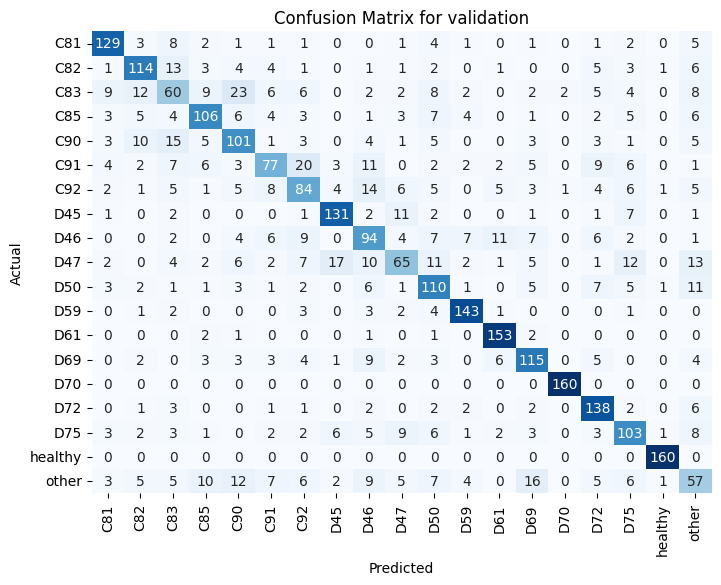


Classification Report:
              precision    recall  f1-score   support

           0      0.791     0.806     0.799       160
           1      0.713     0.713     0.713       160
           2      0.448     0.375     0.408       160
           3      0.702     0.662     0.682       160
           4      0.587     0.631     0.608       160
           5      0.626     0.481     0.544       160
           6      0.549     0.525     0.537       160
           7      0.799     0.819     0.809       160
           8      0.540     0.588     0.563       160
           9      0.575     0.406     0.476       160
          10      0.591     0.688     0.636       160
          11      0.846     0.894     0.869       160
          12      0.841     0.956     0.895       160
          13      0.673     0.719     0.695       160
          14      0.982     1.000     0.991       160
          15      0.708     0.863     0.777       160
          16      0.624     0.644     0.634       160
   

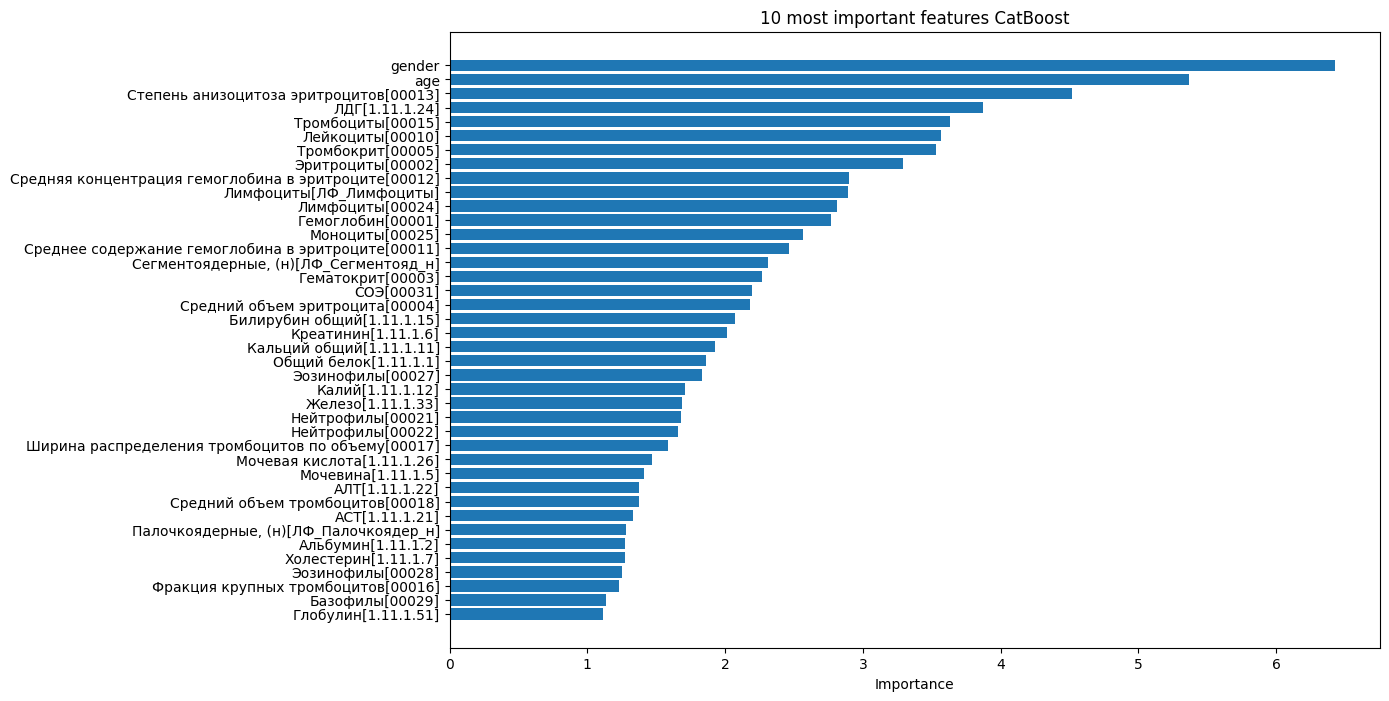

In [31]:
import seaborn as sns
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import shap

cm = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
          xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for validation')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
print(classification_report(y_val, val_preds, digits=3))

feature_importances = best_model.get_feature_importance()
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print("10 most important features:")
print(importance_df.head(10))

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'][:40], importance_df['Importance'][:40])
plt.xlabel('Importance')
plt.title('10 most important features CatBoost')
plt.gca().invert_yaxis()
plt.show()

# best_model.save_model('best_catboost_model.cbm')


The absence of misclassification for healthy clients is a positive result. The trend of classifying CD83 as CD81, CD82, or CD85 likely stems from the similar nature of these diseases (all lymphomas). In clinical practice, these are usually differentiated through methods other than blood tests, so the model's struggle is expected. 

However, we were concerned that age is considered an important feature by the model and wanted to investigate whether it acts as a covariate or a confounder by building a regression model. We were able to prove that it is not a confounder, thus we decided to keep the feature. The same applies to gender.


In [29]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from tqdm import tqdm

def remove_nans(X, y):
    X["target"] = y
    X = X.dropna()
    return X.drop("target", axis=1), X["target"]

X_age_train, X_age_val, y_age_train, y_age_val = train_test_split(
    X_train[["age"]], X_train.drop(["age"], axis=1), test_size=0.2, stratify=y_train, random_state=42)


In [32]:
val_results_age = {}

for column in tqdm(y_age_train.columns):
    X_age_train_column, y_age_train_column = remove_nans(X_age_train, y_age_train[column])
    X_age_val_column, y_age_val_column = remove_nans(X_age_val, y_age_val[column])

    train_age_pool = Pool(X_age_train_column, y_age_train_column)
    val_age_pool = Pool(X_age_train_column, y_age_train_column)

    age_model = CatBoostRegressor(iterations=5000, 
                                learning_rate=0.01,
                                early_stopping_rounds=10,
                                random_state=42, 
                                verbose=0)

    age_model.fit(
        train_age_pool,
        eval_set=val_age_pool,
        use_best_model=True,
        verbose=0
    )
    y_pred_age = age_model.predict(X_age_val_column)

    val_results_age[column] = {
        "n_samples": len(X_age_val_column),
        "MAE": mean_absolute_error(y_age_val_column, y_pred_age),
        "MSE": mean_squared_error(y_age_val_column, y_pred_age),
        "R²": r2_score(y_age_val_column, y_pred_age),
        "MAPE": mean_absolute_percentage_error(y_age_val_column, y_pred_age),
        "Max Error": max(abs(y_age_val_column - y_pred_age))  # Worst-case error
    }

val_results_df = pd.DataFrame(val_results_age).T


100%|██████████| 60/60 [10:15<00:00, 10.26s/it]


In [33]:
val_results_df.sort_values("R²", ascending=False).head(10)

,n_samples,MAE,MSE,R²,MAPE,Max Error
Неорганический фосфор[1.11.1.31],65.0,0.311790,0.182044,0.228905,0.241081,1.337963
Мочевина[1.11.1.5],1677.0,1.656889,7.029886,0.076733,0.298837,24.118724
Альбумин[1.11.1.2],1466.0,3.759830,27.123782,0.043616,0.100198,26.992979
Холестерин[1.11.1.7],768.0,1.170682,2.852067,0.041362,0.265214,18.690347
Степень анизоцитоза эритроцитов[00013],2307.0,2.427041,10.225871,0.028157,0.151377,20.931986
Гамма-глютаминтранспептидаза (ГГТ)[1.11.1.18],835.0,35.069528,5015.985131,0.028075,1.175094,1133.808852
Мочевая кислота[1.11.1.26],1477.0,83.419747,13065.846378,0.027521,0.295076,827.638066
Средний объем эритроцита[00004],2339.0,6.503363,83.732866,0.023252,0.074405,47.185035
Непрямой билирубин[1.11.1.16],559.0,11.429343,386.414245,0.022518,0.864900,126.640812
Калий[1.11.1.12],1097.0,0.364178,0.235427,0.017299,0.085606,3.243005


R² values are generally small (the highest value belongs to the feature with relatively small number of samples), thus the age feature can not explain other features. See EDA for the prove of no correlation.

### Test

In [19]:
test_pool_new = Pool(X_test, y_test)
test_preds = best_model.predict(test_pool_new)
test_proba = best_model.predict_proba(test_pool_new)

results = {}
for metric_name, metric_func in metrics.items():
    if metric_name == "auc_roc":
        results[metric_name] = metric_func(y_test, test_proba)
    else:
        results[metric_name] = metric_func(y_test, test_preds)

In [20]:
for metric_name, score in results.items():
    print(f"{metric_name}: {score}")

accuracy: 0.6736842105263158
f1_micro: 0.6736842105263158
f1_macro: 0.6680396303837906
precision_micro: 0.6736842105263158
precision_macro: 0.6662312785682243
recall_micro: 0.6736842105263158
recall_macro: 0.6736842105263158
auc_roc: 0.9478782163742691


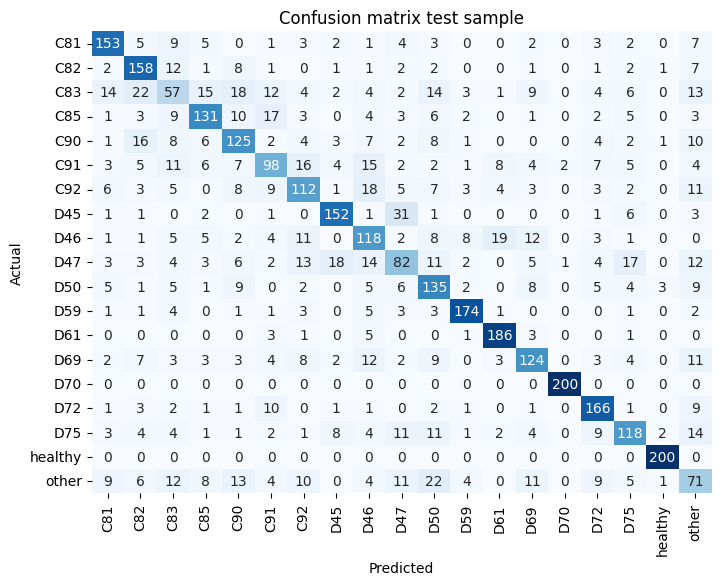


Classification Report:
              precision    recall  f1-score   support

           0      0.743     0.765     0.754       200
           1      0.661     0.790     0.720       200
           2      0.380     0.285     0.326       200
           3      0.697     0.655     0.675       200
           4      0.590     0.625     0.607       200
           5      0.573     0.490     0.528       200
           6      0.586     0.560     0.573       200
           7      0.784     0.760     0.772       200
           8      0.539     0.590     0.563       200
           9      0.488     0.410     0.446       200
          10      0.553     0.675     0.608       200
          11      0.857     0.870     0.864       200
          12      0.830     0.930     0.877       200
          13      0.660     0.620     0.639       200
          14      0.985     1.000     0.993       200
          15      0.741     0.830     0.783       200
          16      0.648     0.590     0.618       200
   

In [28]:
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
          xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion matrix test sample')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, test_preds, digits=3))

We conclude that validation and test metrics are comparable.